In [26]:
!pip install tensorflow

In [27]:
# 📦 1. Imports
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

!pip install opencv-python-headless 

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [28]:
# Define paths
photo_path = "extracted_files/photos"
photos_json_path = "photos.json"  # Adjust the path to your JSON file

# Load JSON data (replace this with the actual JSON structure)
photos_df = pd.read_json(photos_json_path, lines=True)

# Inspect the first few rows
print(photos_df.head())

                 photo_id             business_id  \
0  zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA   
1  HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA   
2  vkr8T0scuJmGVvN2HJelEA  _ab50qdWOk0DdB6XOrBitw   
3  pve7D6NUrafHW3EAORubyw  SZU9c8V2GuREDN5KgyHFJw   
4  H52Er-uBg6rNrHcReWTD2w  Gzur0f0XMkrVxIwYJvOt2g   

                                             caption    label  
0  Nice rock artwork everywhere and craploads of ...   inside  
1                                                     outside  
2                                     oyster shooter    drink  
3                                      Shrimp scampi     food  
4                                                        food  


In [29]:
photos_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200100 entries, 0 to 200099
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   photo_id     200100 non-null  object
 1   business_id  200100 non-null  object
 2   caption      200100 non-null  object
 3   label        200100 non-null  object
dtypes: object(4)
memory usage: 6.1+ MB


In [30]:
# # 🧹 2. Load image labels from JSON
# with open('photos.json', 'r') as f:
#     photos = [json.loads(line) for line in f]

# df = pd.DataFrame(photos)
# df.drop(['business_id', 'caption'], axis=1, inplace=True)
# df.head(10)

In [31]:
photos_df['label'].unique()

array(['inside', 'outside', 'drink', 'food', 'menu'], dtype=object)

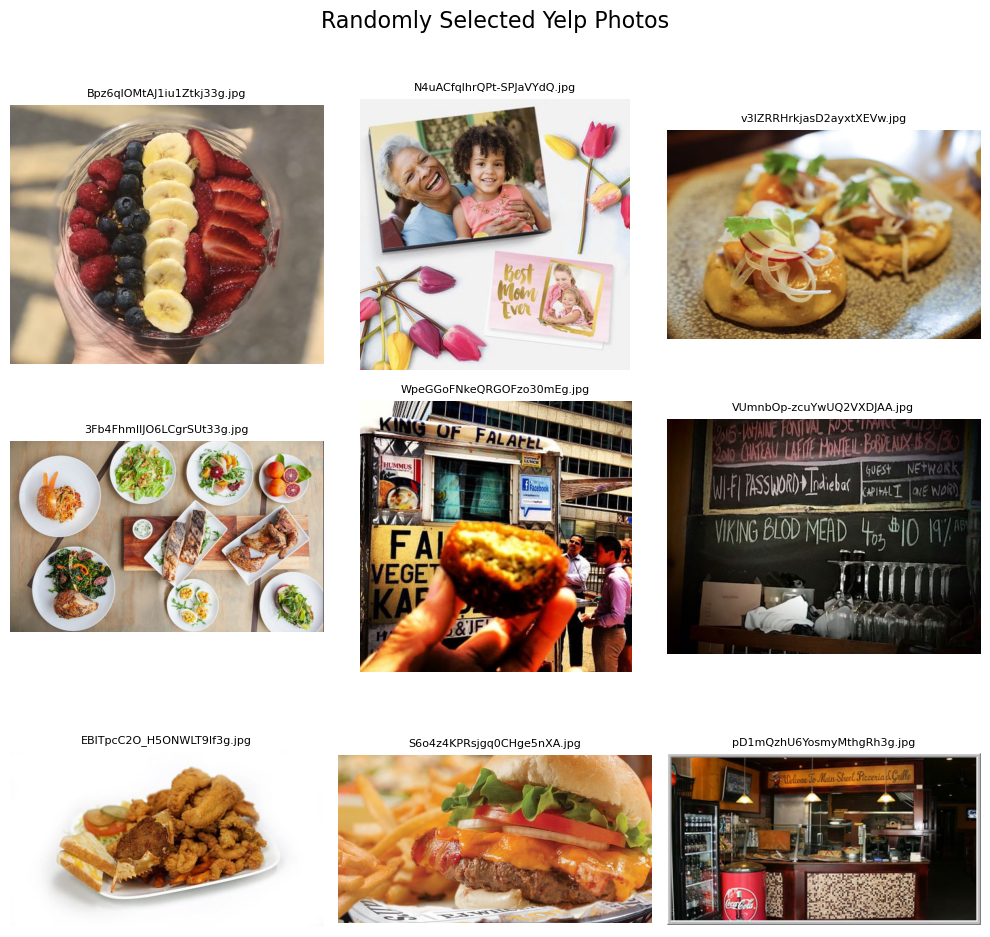

In [32]:
import random

# Path to the folder containing the photos
photos_folder = photo_path

# Get a list of all files in the folder
all_photos = os.listdir(photos_folder)

# Filter out non-image files (optional, if needed)
image_files = [f for f in all_photos if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Pick 9 random images from the list
selected_photos = random.sample(image_files, 9)

# Create a 3x3 grid to display images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.suptitle("Randomly Selected Yelp Photos", fontsize=16)

# Loop through the selected photos and display them
for i, photo in enumerate(selected_photos):
    # Get the full path of the image
    img_path = os.path.join(photos_folder, photo)
    img = Image.open(img_path)  # Open the image
    
    # Calculate the row and column to place the image in
    row, col = divmod(i, 3)
    
    # Display the image
    axes[row, col].imshow(img)
    axes[row, col].axis('off')  # Hide axes
    axes[row, col].set_title(photo, fontsize=8)  # Set the title of the image

# Adjust layout to prevent overlap of titles and images
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot with the images
plt.show()

/var/folders/fg/9nf31wlx7_scn2ycc5nqrhv80000gn/T/ipykernel_7623/447046137.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab20", len(label_counts))  # Using a colormap (tab20) for distinct colors


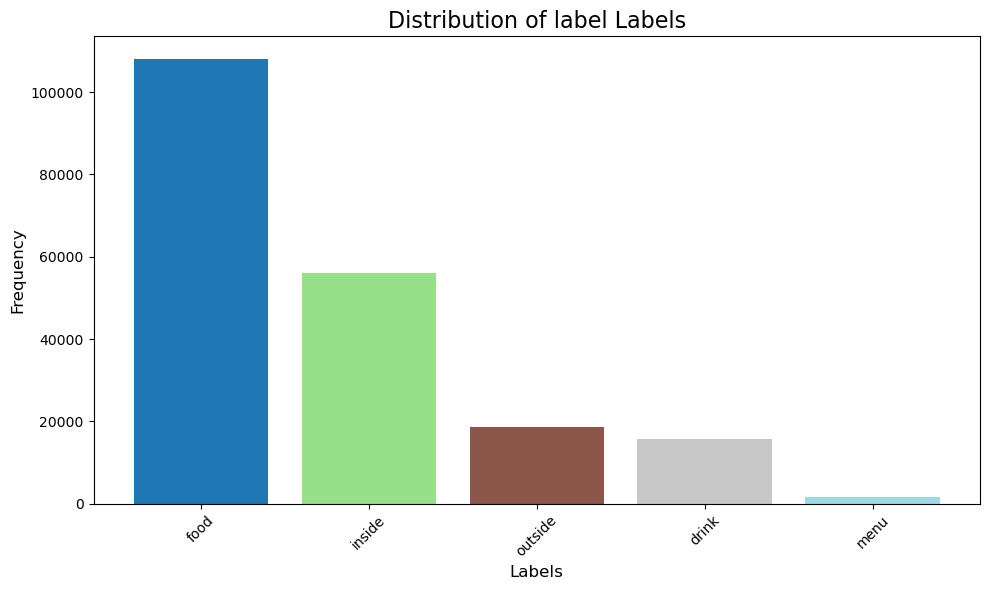

In [33]:
# Check the column names to identify the labels (assuming the column is named 'label' or similar)
if 'category' in photos_df.columns:
    label_column = 'category'
elif 'label' in photos_df.columns:
    label_column = 'label'
else:
    raise ValueError("The JSON file does not contain a label column.")

# Count the occurrences of each label
label_counts = photos_df[label_column].value_counts()

# Generate a list of unique colors (one for each bar)
colors = plt.cm.get_cmap("tab20", len(label_counts))  # Using a colormap (tab20) for distinct colors
color_list = [colors(i) for i in range(len(label_counts))]

# Plot the label distribution with different colors for each bar
plt.figure(figsize=(10, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=color_list)

# Add title and labels
plt.title(f"Distribution of {label_column} Labels", fontsize=16)
plt.xlabel("Labels", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

In [34]:


sampled_data_list = photos_df[['photo_id','label']].to_dict(orient='records')

print(f"Sampled data contains {len(sampled_data_list)} entries.")

Sampled data contains 200100 entries.


In [35]:
import os
import cv2

# Target size for resizing images
TARGET_SIZE = (64, 64)

# Folder where the resized images will be saved
resized_folder = 'ph/preprocessed_photos_resized'

# Create the folder if it doesn't exist
os.makedirs(resized_folder, exist_ok=True)
# Loop through each entry in the data (replace 'sampled_data_list' with your actual data)
for i,entry in enumerate(sampled_data_list):       #sampled_data_list:
    try:
        # Extract the photo ID and construct the image path
        photo_id = entry['photo_id']
        img_path = os.path.join(photos_folder, photo_id + '.jpg')
        # Load the image in original color
        img = cv2.imread(img_path)

        if img is None:
            print(f"{i} Unreadable image: {img_path}")
            continue

        # Resize the image
        img_resized = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)

        # Save the resized image
        save_path = os.path.join(resized_folder, photo_id + '.jpg')
        cv2.imwrite(save_path, img_resized)

    except Exception as e:
        print(f"Error processing {img_path}: {e}")

print("Resizing completed and images saved.")


1597 Unreadable image: extracted_files/photos/ydm3g1wUWSxJnMPgHk2JhQ.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


4226 Unreadable image: extracted_files/photos/JGpfPj8VEvnq1B-Xqr3w-A.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


10792 Unreadable image: extracted_files/photos/bf3ymV0YgP7B6rEoriaU2w.jpg


libpng warning: iCCP: known incorrect sRGB profile


13018 Unreadable image: extracted_files/photos/juDNZOOnkgG3QINFrulsAg.jpg
13775 Unreadable image: extracted_files/photos/9X4YPM8nYFjf7hY8xUdc6Q.jpg
15497 Unreadable image: extracted_files/photos/N6hL8FQ84A2DznF2S2Lp7g.jpg
15954 Unreadable image: extracted_files/photos/pY32hIagdxrL4Nsi959EQg.jpg


libpng warning: iCCP: known incorrect sRGB profile


20045 Unreadable image: extracted_files/photos/cNkUV0sInfh_Py5PP8SHtQ.jpg
21216 Unreadable image: extracted_files/photos/Pk87_8Yndygr4LRUD_H7Hg.jpg
22258 Unreadable image: extracted_files/photos/ke4ohxa93GJz0KH9H2kwsQ.jpg
24788 Unreadable image: extracted_files/photos/rLafN9k3_AF5lZU0cs3LZg.jpg
24842 Unreadable image: extracted_files/photos/-YAvSvGUs2ugiJUvIRO6Jw.jpg


libpng warning: iCCP: known incorrect sRGB profile


26519 Unreadable image: extracted_files/photos/feUGw0P5byOq4U40C77tyQ.jpg
27937 Unreadable image: extracted_files/photos/pW1IPuTdLIUB61goirbXaA.jpg
32175 Unreadable image: extracted_files/photos/RLtBKD2rlfTaELWejmLBCA.jpg
34542 Unreadable image: extracted_files/photos/IB2ZjqjtS1W_DadQoPPdgg.jpg
36934 Unreadable image: extracted_files/photos/43fHlHSYQ_79OBJW1aVUxA.jpg
37588 Unreadable image: extracted_files/photos/QhATx1B1n8uf8C6siMNTfA.jpg
37715 Unreadable image: extracted_files/photos/9RDbbAZB0HnL4hndCWB58w.jpg
38241 Unreadable image: extracted_files/photos/1wd_eyhMrTqUmicDmn4_Kw.jpg


libpng warning: iCCP: known incorrect sRGB profile


39508 Unreadable image: extracted_files/photos/W94rrCn0O5K1lkfD26m4tw.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


41946 Unreadable image: extracted_files/photos/n6Q9vNuxz7786ESEfautxQ.jpg
42770 Unreadable image: extracted_files/photos/YW1WMOkVbdFBrixDnKgoqA.jpg
43639 Unreadable image: extracted_files/photos/hjEfal2a1DWRDu8_AUDLNg.jpg
44016 Unreadable image: extracted_files/photos/0TpeNZPs3Gu8s30KVXudcg.jpg
44194 Unreadable image: extracted_files/photos/AMSyCOP3-Eb_ivNA8w1Vhw.jpg
44820 Unreadable image: extracted_files/photos/TvD36_DdnyCJuXV1SSt3_Q.jpg


libpng warning: iCCP: known incorrect sRGB profile


46698 Unreadable image: extracted_files/photos/rrfwGSwt3eHxxypfu5PGTA.jpg
48681 Unreadable image: extracted_files/photos/qMlGILrsrzhMDxajNYiyIA.jpg
50014 Unreadable image: extracted_files/photos/jU-dKl2Ye4L_5x602yoctQ.jpg
51845 Unreadable image: extracted_files/photos/TN4-gAea6ejAdZ-NzYXxng.jpg
51989 Unreadable image: extracted_files/photos/IkGbGxI8IoOCuVsNB0VLrA.jpg
52621 Unreadable image: extracted_files/photos/nKJ7yiPc0E_DJNtNxmCrhg.jpg
52769 Unreadable image: extracted_files/photos/E7Wpzn-1fCnVJ8_zKpecPQ.jpg
54570 Unreadable image: extracted_files/photos/MduVueqYTBlEkX-axrh1ug.jpg
54941 Unreadable image: extracted_files/photos/ytJ4lihJrvyzMMRG-WwDNw.jpg


libpng warning: iCCP: known incorrect sRGB profile


57267 Unreadable image: extracted_files/photos/-BIybLxzoFt2d2zbYRcfHA.jpg
57837 Unreadable image: extracted_files/photos/RhC7TNmFvbR9GWrlrl5dsA.jpg
60493 Unreadable image: extracted_files/photos/OK6HsALzFcBAUlrroKHZGg.jpg


libpng warning: iCCP: known incorrect sRGB profile


61630 Unreadable image: extracted_files/photos/CBxmBYD_5CXIL_F-2PDqmA.jpg
64772 Unreadable image: extracted_files/photos/K6pfRNwGodm1m1gFVQlj-Q.jpg
65262 Unreadable image: extracted_files/photos/JoQ5xekjQUkj8rukJIzqgg.jpg
68658 Unreadable image: extracted_files/photos/yFjqHyOaNFwzIWTV8EE9hg.jpg


libpng warning: iCCP: known incorrect sRGB profile


70831 Unreadable image: extracted_files/photos/hclqCX1FWcV_TtJJoI3BpQ.jpg
74761 Unreadable image: extracted_files/photos/JG5s_bvRF1cSWf1fk9lTbw.jpg


libpng warning: iCCP: known incorrect sRGB profile


77445 Unreadable image: extracted_files/photos/kjMBhxBXOUE7SSUQb-YQbw.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


82767 Unreadable image: extracted_files/photos/DMCTwC3UT2w5QzHOQoqBPw.jpg
87330 Unreadable image: extracted_files/photos/1MOGQBWogR8oJr1WgERi9g.jpg
87414 Unreadable image: extracted_files/photos/WGmGujPl5BmR_fCUZnoe9w.jpg


libpng warning: iCCP: known incorrect sRGB profile


99518 Unreadable image: extracted_files/photos/w5ABnSadHC8z1lthMQBaBQ.jpg
101495 Unreadable image: extracted_files/photos/zTzdu2QqLozHpW_qYWF84w.jpg
105821 Unreadable image: extracted_files/photos/2S78q98b_VpBD7vkrDE5-A.jpg
107362 Unreadable image: extracted_files/photos/yhztPWh5IhaePpUQJNW-dQ.jpg
107838 Unreadable image: extracted_files/photos/AkiGRjaMKHdJyV7bdHsQjw.jpg
107929 Unreadable image: extracted_files/photos/NKEFWvRriK-LvagPz2QRxw.jpg


libpng warning: iCCP: known incorrect sRGB profile


112382 Unreadable image: extracted_files/photos/c73YwNh1JsYR5Hz-u_bOrg.jpg


libpng warning: iCCP: known incorrect sRGB profile


114758 Unreadable image: extracted_files/photos/PjfJoBrEFgDrxiJy8nyatA.jpg
115384 Unreadable image: extracted_files/photos/LXT4hCf1lRyUeM4HDBaSvg.jpg
116845 Unreadable image: extracted_files/photos/XX6ujA9CcB5s9y9wCy67-Q.jpg


libpng warning: iCCP: known incorrect sRGB profile


119033 Unreadable image: extracted_files/photos/IUsKp87a-v9Yhx6Ftg1m5A.jpg
119072 Unreadable image: extracted_files/photos/QRUo4vqUu3X9V4eIqBpY8A.jpg


libpng warning: iCCP: known incorrect sRGB profile


120989 Unreadable image: extracted_files/photos/Y3lA41pnMkQNGfyREkf6SA.jpg
121526 Unreadable image: extracted_files/photos/5q-sAvIPl0yNeuAbNBPM1g.jpg
124087 Unreadable image: extracted_files/photos/PFD3ykdI1WVhvZ8IX4PmLQ.jpg
125297 Unreadable image: extracted_files/photos/MZj64XNUN6Og178-6XYR6g.jpg
126015 Unreadable image: extracted_files/photos/yAf6R6OSgPo8-mmdDh8qIw.jpg
126279 Unreadable image: extracted_files/photos/l_rMdwgrvjm2PyHyXBcBTw.jpg
126459 Unreadable image: extracted_files/photos/IExxMfr1h0bxw54jsanyKA.jpg
128216 Unreadable image: extracted_files/photos/-NGY_19QK2zq913HdiYc5A.jpg


libpng warning: iCCP: known incorrect sRGB profile


129696 Unreadable image: extracted_files/photos/aUDiJhcFKt0exhyj4Q23Ow.jpg
129899 Unreadable image: extracted_files/photos/LhLfsQtYwJ5OmEzilubhXQ.jpg
130027 Unreadable image: extracted_files/photos/l2vR3PyVMF3pgIERdDEuiQ.jpg
130626 Unreadable image: extracted_files/photos/0fac-NlXqfBO2pWRkmM9aw.jpg
131129 Unreadable image: extracted_files/photos/O0bVFyP58TOEix6IjERXQA.jpg
131311 Unreadable image: extracted_files/photos/t_sV6mI4oNvbvohhZAyeuA.jpg
132819 Unreadable image: extracted_files/photos/_exWW0g4Svg1Eo2YWsGzbg.jpg
140892 Unreadable image: extracted_files/photos/-ZkmgGLJ7AJTjy96nocMNw.jpg
141623 Unreadable image: extracted_files/photos/JZZ716oX6_MqH6L_MkWK-A.jpg
144917 Unreadable image: extracted_files/photos/7xcWPjcE4mxoQ1AjvvKJZg.jpg


libpng warning: iCCP: known incorrect sRGB profile


149118 Unreadable image: extracted_files/photos/lrfy4UVIWtj0xwboLgUreQ.jpg
153898 Unreadable image: extracted_files/photos/tlp6LCLDsvL1GjO_kW_plQ.jpg
154592 Unreadable image: extracted_files/photos/B7xR9CuhRpP52PoehQHVow.jpg
157069 Unreadable image: extracted_files/photos/qxSXsYMA3aWuAfigeqeOOQ.jpg


libpng warning: iCCP: known incorrect sRGB profile


159294 Unreadable image: extracted_files/photos/74upe0h6XxwgzqpdnAh_7Q.jpg
162704 Unreadable image: extracted_files/photos/6bKuH4FOdaaPInF9NmlQHQ.jpg
165116 Unreadable image: extracted_files/photos/UG2JuFFa_WxhPEtMOtq-JQ.jpg
166658 Unreadable image: extracted_files/photos/tSHz7RzlgceAItRejZ396A.jpg
166925 Unreadable image: extracted_files/photos/GPMWGVjuCsa6fadnZsEplw.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


170823 Unreadable image: extracted_files/photos/RIeulJUzgemFugkkgg4qgA.jpg
171182 Unreadable image: extracted_files/photos/CA9z96gGA4y9QOes2Y9eGw.jpg
171652 Unreadable image: extracted_files/photos/amM65inTV6wvx0NNZN5qhg.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


172816 Unreadable image: extracted_files/photos/C6n0nKVbgLbYmxSiQ_bFsg.jpg


libpng warning: iCCP: known incorrect sRGB profile


175829 Unreadable image: extracted_files/photos/j5-4lzg23yGECBa6l1fyRQ.jpg
175908 Unreadable image: extracted_files/photos/gJH0d6Sut4eZDlbV0GCByg.jpg
176493 Unreadable image: extracted_files/photos/hChXG-gGWxzGvalse3EYmw.jpg
177508 Unreadable image: extracted_files/photos/VSekUmmsGZcX7KaPe_hXyw.jpg


libpng warning: iCCP: known incorrect sRGB profile


182545 Unreadable image: extracted_files/photos/9BvYOtforBBP6MvvDogtmw.jpg
183389 Unreadable image: extracted_files/photos/rIhUkEmP-j4NcQVW3YuPYQ.jpg
186685 Unreadable image: extracted_files/photos/NfayhoTudVJQsEF-XlPyjw.jpg
190142 Unreadable image: extracted_files/photos/m3oIKhKKCQD54y1E-dBKSw.jpg
191811 Unreadable image: extracted_files/photos/cwwoZcpqdu2MwdDusNyTdg.jpg
192064 Unreadable image: extracted_files/photos/DB7BlUpO4LAmC1lCN62hqg.jpg
194198 Unreadable image: extracted_files/photos/ARwqGQZaT0p-XpYYjMXgQg.jpg
194245 Unreadable image: extracted_files/photos/9jBH61ndIcsheo6FtIHArA.jpg


libpng warning: iCCP: known incorrect sRGB profile


197770 Unreadable image: extracted_files/photos/iX-8Xm2G7meRHUg8qhoL1A.jpg
199223 Unreadable image: extracted_files/photos/GWLmPwKeBnh2b_7Kv_LQ7w.jpg
Resizing completed and images saved.


In [36]:
# List to store IDs of corrupted or unreadable images
corrupted_ids = []

# Folder to save thresholded images (output)
preprocessed_folder = 'ph/preprocessed_photos'
os.makedirs(preprocessed_folder, exist_ok=True)

# Loop through each image in sampled_data_list
for entry in sampled_data_list[:]:  # Use a copy to avoid modifying the list while iterating
    photo_id = entry['photo_id']
    img_path = os.path.join(resized_folder, photo_id + '.jpg')

    try:
        # Load image in grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Check if the image loaded properly
        if img is None:
            raise ValueError(f"Unreadable image: {img_path}")

        # Normalize pixel intensities to range [0, 255]
        img_normalized = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

        # Apply binary thresholding with threshold value 128
        _, img_thresholded = cv2.threshold(img_normalized, 128, 255, cv2.THRESH_BINARY)

        # Construct the save path
        save_path = os.path.join(preprocessed_folder, photo_id + '_thresholded.jpg')

        # Save the thresholded image if it's valid
        if img_thresholded is not None and img_thresholded.size > 0:
            result = cv2.imwrite(save_path, img_thresholded)
            if result:
                pass
            else:
                print(f"Failed to save image: {save_path}")
        else:
            print(f"Thresholded image is empty: {save_path}")

    except Exception as e:
        print(f"Corrupted image detected: {img_path} - Error: {e}")
        corrupted_ids.append(photo_id)

# Filter out corrupted entries from the list
sampled_data_list = [entry for entry in sampled_data_list if entry['photo_id'] not in corrupted_ids]

# Print final summary
print(f"Removed {len(corrupted_ids)} corrupted images.")
print("Intensity thresholding completed and images saved.")


Corrupted image detected: ph/preprocessed_photos_resized/ydm3g1wUWSxJnMPgHk2JhQ.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/ydm3g1wUWSxJnMPgHk2JhQ.jpg


[ WARN:0@489.640] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/ydm3g1wUWSxJnMPgHk2JhQ.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/JGpfPj8VEvnq1B-Xqr3w-A.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/JGpfPj8VEvnq1B-Xqr3w-A.jpg


[ WARN:0@490.037] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/JGpfPj8VEvnq1B-Xqr3w-A.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/bf3ymV0YgP7B6rEoriaU2w.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/bf3ymV0YgP7B6rEoriaU2w.jpg


[ WARN:0@491.216] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/bf3ymV0YgP7B6rEoriaU2w.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/juDNZOOnkgG3QINFrulsAg.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/juDNZOOnkgG3QINFrulsAg.jpg
Corrupted image detected: ph/preprocessed_photos_resized/9X4YPM8nYFjf7hY8xUdc6Q.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/9X4YPM8nYFjf7hY8xUdc6Q.jpg


[ WARN:0@491.594] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/juDNZOOnkgG3QINFrulsAg.jpg'): can't open/read file: check file path/integrity
[ WARN:0@491.713] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/9X4YPM8nYFjf7hY8xUdc6Q.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/N6hL8FQ84A2DznF2S2Lp7g.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/N6hL8FQ84A2DznF2S2Lp7g.jpg
Corrupted image detected: ph/preprocessed_photos_resized/pY32hIagdxrL4Nsi959EQg.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/pY32hIagdxrL4Nsi959EQg.jpg


[ WARN:0@491.995] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/N6hL8FQ84A2DznF2S2Lp7g.jpg'): can't open/read file: check file path/integrity
[ WARN:0@492.064] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/pY32hIagdxrL4Nsi959EQg.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/cNkUV0sInfh_Py5PP8SHtQ.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/cNkUV0sInfh_Py5PP8SHtQ.jpg
Corrupted image detected: ph/preprocessed_photos_resized/Pk87_8Yndygr4LRUD_H7Hg.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/Pk87_8Yndygr4LRUD_H7Hg.jpg


[ WARN:0@492.679] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/cNkUV0sInfh_Py5PP8SHtQ.jpg'): can't open/read file: check file path/integrity
[ WARN:0@492.844] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/Pk87_8Yndygr4LRUD_H7Hg.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/ke4ohxa93GJz0KH9H2kwsQ.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/ke4ohxa93GJz0KH9H2kwsQ.jpg


[ WARN:0@493.033] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/ke4ohxa93GJz0KH9H2kwsQ.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/rLafN9k3_AF5lZU0cs3LZg.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/rLafN9k3_AF5lZU0cs3LZg.jpg
Corrupted image detected: ph/preprocessed_photos_resized/-YAvSvGUs2ugiJUvIRO6Jw.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/-YAvSvGUs2ugiJUvIRO6Jw.jpg


[ WARN:0@493.452] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/rLafN9k3_AF5lZU0cs3LZg.jpg'): can't open/read file: check file path/integrity
[ WARN:0@493.460] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/-YAvSvGUs2ugiJUvIRO6Jw.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/feUGw0P5byOq4U40C77tyQ.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/feUGw0P5byOq4U40C77tyQ.jpg


[ WARN:0@493.722] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/feUGw0P5byOq4U40C77tyQ.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/pW1IPuTdLIUB61goirbXaA.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/pW1IPuTdLIUB61goirbXaA.jpg


[ WARN:0@493.959] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/pW1IPuTdLIUB61goirbXaA.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/RLtBKD2rlfTaELWejmLBCA.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/RLtBKD2rlfTaELWejmLBCA.jpg


[ WARN:0@494.679] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/RLtBKD2rlfTaELWejmLBCA.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/IB2ZjqjtS1W_DadQoPPdgg.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/IB2ZjqjtS1W_DadQoPPdgg.jpg


[ WARN:0@495.131] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/IB2ZjqjtS1W_DadQoPPdgg.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/43fHlHSYQ_79OBJW1aVUxA.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/43fHlHSYQ_79OBJW1aVUxA.jpg
Corrupted image detected: ph/preprocessed_photos_resized/QhATx1B1n8uf8C6siMNTfA.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/QhATx1B1n8uf8C6siMNTfA.jpg
Corrupted image detected: ph/preprocessed_photos_resized/9RDbbAZB0HnL4hndCWB58w.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/9RDbbAZB0HnL4hndCWB58w.jpg


[ WARN:0@495.557] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/43fHlHSYQ_79OBJW1aVUxA.jpg'): can't open/read file: check file path/integrity
[ WARN:0@495.692] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/QhATx1B1n8uf8C6siMNTfA.jpg'): can't open/read file: check file path/integrity
[ WARN:0@495.711] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/9RDbbAZB0HnL4hndCWB58w.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/1wd_eyhMrTqUmicDmn4_Kw.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/1wd_eyhMrTqUmicDmn4_Kw.jpg


[ WARN:0@495.817] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/1wd_eyhMrTqUmicDmn4_Kw.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/W94rrCn0O5K1lkfD26m4tw.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/W94rrCn0O5K1lkfD26m4tw.jpg


[ WARN:0@496.038] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/W94rrCn0O5K1lkfD26m4tw.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/n6Q9vNuxz7786ESEfautxQ.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/n6Q9vNuxz7786ESEfautxQ.jpg
Corrupted image detected: ph/preprocessed_photos_resized/YW1WMOkVbdFBrixDnKgoqA.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/YW1WMOkVbdFBrixDnKgoqA.jpg


[ WARN:0@496.461] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/n6Q9vNuxz7786ESEfautxQ.jpg'): can't open/read file: check file path/integrity
[ WARN:0@496.617] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/YW1WMOkVbdFBrixDnKgoqA.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/hjEfal2a1DWRDu8_AUDLNg.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/hjEfal2a1DWRDu8_AUDLNg.jpg
Corrupted image detected: ph/preprocessed_photos_resized/0TpeNZPs3Gu8s30KVXudcg.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/0TpeNZPs3Gu8s30KVXudcg.jpg
Corrupted image detected: ph/preprocessed_photos_resized/AMSyCOP3-Eb_ivNA8w1Vhw.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/AMSyCOP3-Eb_ivNA8w1Vhw.jpg


[ WARN:0@496.804] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/hjEfal2a1DWRDu8_AUDLNg.jpg'): can't open/read file: check file path/integrity
[ WARN:0@496.870] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/0TpeNZPs3Gu8s30KVXudcg.jpg'): can't open/read file: check file path/integrity
[ WARN:0@496.897] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/AMSyCOP3-Eb_ivNA8w1Vhw.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/TvD36_DdnyCJuXV1SSt3_Q.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/TvD36_DdnyCJuXV1SSt3_Q.jpg


[ WARN:0@497.013] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/TvD36_DdnyCJuXV1SSt3_Q.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/rrfwGSwt3eHxxypfu5PGTA.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/rrfwGSwt3eHxxypfu5PGTA.jpg


[ WARN:0@497.335] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/rrfwGSwt3eHxxypfu5PGTA.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/qMlGILrsrzhMDxajNYiyIA.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/qMlGILrsrzhMDxajNYiyIA.jpg


[ WARN:0@497.707] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/qMlGILrsrzhMDxajNYiyIA.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/jU-dKl2Ye4L_5x602yoctQ.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/jU-dKl2Ye4L_5x602yoctQ.jpg


[ WARN:0@497.986] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/jU-dKl2Ye4L_5x602yoctQ.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/TN4-gAea6ejAdZ-NzYXxng.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/TN4-gAea6ejAdZ-NzYXxng.jpg
Corrupted image detected: ph/preprocessed_photos_resized/IkGbGxI8IoOCuVsNB0VLrA.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/IkGbGxI8IoOCuVsNB0VLrA.jpg
Corrupted image detected: ph/preprocessed_photos_resized/nKJ7yiPc0E_DJNtNxmCrhg.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/nKJ7yiPc0E_DJNtNxmCrhg.jpg
Corrupted image detected: ph/preprocessed_photos_resized/E7Wpzn-1fCnVJ8_zKpecPQ.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/E7Wpzn-1fCnVJ8_zKpecPQ.jpg


[ WARN:0@498.328] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/TN4-gAea6ejAdZ-NzYXxng.jpg'): can't open/read file: check file path/integrity
[ WARN:0@498.350] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/IkGbGxI8IoOCuVsNB0VLrA.jpg'): can't open/read file: check file path/integrity
[ WARN:0@498.463] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/nKJ7yiPc0E_DJNtNxmCrhg.jpg'): can't open/read file: check file path/integrity
[ WARN:0@498.484] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/E7Wpzn-1fCnVJ8_zKpecPQ.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/MduVueqYTBlEkX-axrh1ug.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/MduVueqYTBlEkX-axrh1ug.jpg
Corrupted image detected: ph/preprocessed_photos_resized/ytJ4lihJrvyzMMRG-WwDNw.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/ytJ4lihJrvyzMMRG-WwDNw.jpg


[ WARN:0@498.845] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/MduVueqYTBlEkX-axrh1ug.jpg'): can't open/read file: check file path/integrity
[ WARN:0@498.900] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/ytJ4lihJrvyzMMRG-WwDNw.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/-BIybLxzoFt2d2zbYRcfHA.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/-BIybLxzoFt2d2zbYRcfHA.jpg
Corrupted image detected: ph/preprocessed_photos_resized/RhC7TNmFvbR9GWrlrl5dsA.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/RhC7TNmFvbR9GWrlrl5dsA.jpg


[ WARN:0@499.325] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/-BIybLxzoFt2d2zbYRcfHA.jpg'): can't open/read file: check file path/integrity
[ WARN:0@499.432] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/RhC7TNmFvbR9GWrlrl5dsA.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/OK6HsALzFcBAUlrroKHZGg.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/OK6HsALzFcBAUlrroKHZGg.jpg
Corrupted image detected: ph/preprocessed_photos_resized/CBxmBYD_5CXIL_F-2PDqmA.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/CBxmBYD_5CXIL_F-2PDqmA.jpg


[ WARN:0@499.909] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/OK6HsALzFcBAUlrroKHZGg.jpg'): can't open/read file: check file path/integrity
[ WARN:0@500.103] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/CBxmBYD_5CXIL_F-2PDqmA.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/K6pfRNwGodm1m1gFVQlj-Q.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/K6pfRNwGodm1m1gFVQlj-Q.jpg
Corrupted image detected: ph/preprocessed_photos_resized/JoQ5xekjQUkj8rukJIzqgg.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/JoQ5xekjQUkj8rukJIzqgg.jpg


[ WARN:0@500.641] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/K6pfRNwGodm1m1gFVQlj-Q.jpg'): can't open/read file: check file path/integrity
[ WARN:0@500.732] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/JoQ5xekjQUkj8rukJIzqgg.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/yFjqHyOaNFwzIWTV8EE9hg.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/yFjqHyOaNFwzIWTV8EE9hg.jpg


[ WARN:0@501.346] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/yFjqHyOaNFwzIWTV8EE9hg.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/hclqCX1FWcV_TtJJoI3BpQ.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/hclqCX1FWcV_TtJJoI3BpQ.jpg


[ WARN:0@501.765] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/hclqCX1FWcV_TtJJoI3BpQ.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/JG5s_bvRF1cSWf1fk9lTbw.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/JG5s_bvRF1cSWf1fk9lTbw.jpg


[ WARN:0@502.500] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/JG5s_bvRF1cSWf1fk9lTbw.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/kjMBhxBXOUE7SSUQb-YQbw.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/kjMBhxBXOUE7SSUQb-YQbw.jpg


[ WARN:0@502.997] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/kjMBhxBXOUE7SSUQb-YQbw.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/DMCTwC3UT2w5QzHOQoqBPw.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/DMCTwC3UT2w5QzHOQoqBPw.jpg


[ WARN:0@503.951] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/DMCTwC3UT2w5QzHOQoqBPw.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/1MOGQBWogR8oJr1WgERi9g.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/1MOGQBWogR8oJr1WgERi9g.jpg
Corrupted image detected: ph/preprocessed_photos_resized/WGmGujPl5BmR_fCUZnoe9w.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/WGmGujPl5BmR_fCUZnoe9w.jpg


[ WARN:0@504.780] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/1MOGQBWogR8oJr1WgERi9g.jpg'): can't open/read file: check file path/integrity
[ WARN:0@504.792] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/WGmGujPl5BmR_fCUZnoe9w.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/w5ABnSadHC8z1lthMQBaBQ.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/w5ABnSadHC8z1lthMQBaBQ.jpg


[ WARN:0@506.860] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/w5ABnSadHC8z1lthMQBaBQ.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/zTzdu2QqLozHpW_qYWF84w.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/zTzdu2QqLozHpW_qYWF84w.jpg


[ WARN:0@507.161] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/zTzdu2QqLozHpW_qYWF84w.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/2S78q98b_VpBD7vkrDE5-A.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/2S78q98b_VpBD7vkrDE5-A.jpg


[ WARN:0@507.916] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/2S78q98b_VpBD7vkrDE5-A.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/yhztPWh5IhaePpUQJNW-dQ.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/yhztPWh5IhaePpUQJNW-dQ.jpg
Corrupted image detected: ph/preprocessed_photos_resized/AkiGRjaMKHdJyV7bdHsQjw.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/AkiGRjaMKHdJyV7bdHsQjw.jpg
Corrupted image detected: ph/preprocessed_photos_resized/NKEFWvRriK-LvagPz2QRxw.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/NKEFWvRriK-LvagPz2QRxw.jpg


[ WARN:0@508.210] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/yhztPWh5IhaePpUQJNW-dQ.jpg'): can't open/read file: check file path/integrity
[ WARN:0@508.304] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/AkiGRjaMKHdJyV7bdHsQjw.jpg'): can't open/read file: check file path/integrity
[ WARN:0@508.316] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/NKEFWvRriK-LvagPz2QRxw.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/c73YwNh1JsYR5Hz-u_bOrg.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/c73YwNh1JsYR5Hz-u_bOrg.jpg


[ WARN:0@509.076] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/c73YwNh1JsYR5Hz-u_bOrg.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/PjfJoBrEFgDrxiJy8nyatA.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/PjfJoBrEFgDrxiJy8nyatA.jpg
Corrupted image detected: ph/preprocessed_photos_resized/LXT4hCf1lRyUeM4HDBaSvg.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/LXT4hCf1lRyUeM4HDBaSvg.jpg


[ WARN:0@509.475] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/PjfJoBrEFgDrxiJy8nyatA.jpg'): can't open/read file: check file path/integrity
[ WARN:0@509.590] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/LXT4hCf1lRyUeM4HDBaSvg.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/XX6ujA9CcB5s9y9wCy67-Q.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/XX6ujA9CcB5s9y9wCy67-Q.jpg


[ WARN:0@509.838] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/XX6ujA9CcB5s9y9wCy67-Q.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/IUsKp87a-v9Yhx6Ftg1m5A.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/IUsKp87a-v9Yhx6Ftg1m5A.jpg
Corrupted image detected: ph/preprocessed_photos_resized/QRUo4vqUu3X9V4eIqBpY8A.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/QRUo4vqUu3X9V4eIqBpY8A.jpg


[ WARN:0@510.209] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/IUsKp87a-v9Yhx6Ftg1m5A.jpg'): can't open/read file: check file path/integrity
[ WARN:0@510.216] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/QRUo4vqUu3X9V4eIqBpY8A.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/Y3lA41pnMkQNGfyREkf6SA.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/Y3lA41pnMkQNGfyREkf6SA.jpg
Corrupted image detected: ph/preprocessed_photos_resized/5q-sAvIPl0yNeuAbNBPM1g.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/5q-sAvIPl0yNeuAbNBPM1g.jpg


[ WARN:0@510.536] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/Y3lA41pnMkQNGfyREkf6SA.jpg'): can't open/read file: check file path/integrity
[ WARN:0@510.625] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/5q-sAvIPl0yNeuAbNBPM1g.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/PFD3ykdI1WVhvZ8IX4PmLQ.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/PFD3ykdI1WVhvZ8IX4PmLQ.jpg


[ WARN:0@511.078] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/PFD3ykdI1WVhvZ8IX4PmLQ.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/MZj64XNUN6Og178-6XYR6g.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/MZj64XNUN6Og178-6XYR6g.jpg
Corrupted image detected: ph/preprocessed_photos_resized/yAf6R6OSgPo8-mmdDh8qIw.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/yAf6R6OSgPo8-mmdDh8qIw.jpg
Corrupted image detected: ph/preprocessed_photos_resized/l_rMdwgrvjm2PyHyXBcBTw.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/l_rMdwgrvjm2PyHyXBcBTw.jpg


[ WARN:0@511.294] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/MZj64XNUN6Og178-6XYR6g.jpg'): can't open/read file: check file path/integrity
[ WARN:0@511.421] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/yAf6R6OSgPo8-mmdDh8qIw.jpg'): can't open/read file: check file path/integrity
[ WARN:0@511.464] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/l_rMdwgrvjm2PyHyXBcBTw.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/IExxMfr1h0bxw54jsanyKA.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/IExxMfr1h0bxw54jsanyKA.jpg


[ WARN:0@511.503] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/IExxMfr1h0bxw54jsanyKA.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/-NGY_19QK2zq913HdiYc5A.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/-NGY_19QK2zq913HdiYc5A.jpg


[ WARN:0@511.825] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/-NGY_19QK2zq913HdiYc5A.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/aUDiJhcFKt0exhyj4Q23Ow.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/aUDiJhcFKt0exhyj4Q23Ow.jpg
Corrupted image detected: ph/preprocessed_photos_resized/LhLfsQtYwJ5OmEzilubhXQ.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/LhLfsQtYwJ5OmEzilubhXQ.jpg
Corrupted image detected: ph/preprocessed_photos_resized/l2vR3PyVMF3pgIERdDEuiQ.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/l2vR3PyVMF3pgIERdDEuiQ.jpg
Corrupted image detected: ph/preprocessed_photos_resized/0fac-NlXqfBO2pWRkmM9aw.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/0fac-NlXqfBO2pWRkmM9aw.jpg


[ WARN:0@512.079] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/aUDiJhcFKt0exhyj4Q23Ow.jpg'): can't open/read file: check file path/integrity
[ WARN:0@512.130] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/LhLfsQtYwJ5OmEzilubhXQ.jpg'): can't open/read file: check file path/integrity
[ WARN:0@512.150] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/l2vR3PyVMF3pgIERdDEuiQ.jpg'): can't open/read file: check file path/integrity
[ WARN:0@512.256] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/0fac-NlXqfBO2pWRkmM9aw.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/O0bVFyP58TOEix6IjERXQA.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/O0bVFyP58TOEix6IjERXQA.jpg
Corrupted image detected: ph/preprocessed_photos_resized/t_sV6mI4oNvbvohhZAyeuA.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/t_sV6mI4oNvbvohhZAyeuA.jpg


[ WARN:0@512.351] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/O0bVFyP58TOEix6IjERXQA.jpg'): can't open/read file: check file path/integrity
[ WARN:0@512.382] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/t_sV6mI4oNvbvohhZAyeuA.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/_exWW0g4Svg1Eo2YWsGzbg.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/_exWW0g4Svg1Eo2YWsGzbg.jpg


[ WARN:0@512.703] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/_exWW0g4Svg1Eo2YWsGzbg.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/-ZkmgGLJ7AJTjy96nocMNw.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/-ZkmgGLJ7AJTjy96nocMNw.jpg
Corrupted image detected: ph/preprocessed_photos_resized/JZZ716oX6_MqH6L_MkWK-A.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/JZZ716oX6_MqH6L_MkWK-A.jpg


[ WARN:0@514.183] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/-ZkmgGLJ7AJTjy96nocMNw.jpg'): can't open/read file: check file path/integrity
[ WARN:0@514.311] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/JZZ716oX6_MqH6L_MkWK-A.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/7xcWPjcE4mxoQ1AjvvKJZg.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/7xcWPjcE4mxoQ1AjvvKJZg.jpg


[ WARN:0@514.924] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/7xcWPjcE4mxoQ1AjvvKJZg.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/lrfy4UVIWtj0xwboLgUreQ.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/lrfy4UVIWtj0xwboLgUreQ.jpg


[ WARN:0@515.700] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/lrfy4UVIWtj0xwboLgUreQ.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/tlp6LCLDsvL1GjO_kW_plQ.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/tlp6LCLDsvL1GjO_kW_plQ.jpg
Corrupted image detected: ph/preprocessed_photos_resized/B7xR9CuhRpP52PoehQHVow.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/B7xR9CuhRpP52PoehQHVow.jpg


[ WARN:0@516.515] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/tlp6LCLDsvL1GjO_kW_plQ.jpg'): can't open/read file: check file path/integrity
[ WARN:0@516.642] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/B7xR9CuhRpP52PoehQHVow.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/qxSXsYMA3aWuAfigeqeOOQ.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/qxSXsYMA3aWuAfigeqeOOQ.jpg


[ WARN:0@517.059] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/qxSXsYMA3aWuAfigeqeOOQ.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/74upe0h6XxwgzqpdnAh_7Q.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/74upe0h6XxwgzqpdnAh_7Q.jpg


[ WARN:0@517.433] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/74upe0h6XxwgzqpdnAh_7Q.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/6bKuH4FOdaaPInF9NmlQHQ.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/6bKuH4FOdaaPInF9NmlQHQ.jpg


[ WARN:0@518.036] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/6bKuH4FOdaaPInF9NmlQHQ.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/UG2JuFFa_WxhPEtMOtq-JQ.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/UG2JuFFa_WxhPEtMOtq-JQ.jpg


[ WARN:0@518.489] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/UG2JuFFa_WxhPEtMOtq-JQ.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/tSHz7RzlgceAItRejZ396A.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/tSHz7RzlgceAItRejZ396A.jpg
Corrupted image detected: ph/preprocessed_photos_resized/GPMWGVjuCsa6fadnZsEplw.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/GPMWGVjuCsa6fadnZsEplw.jpg


[ WARN:0@518.778] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/tSHz7RzlgceAItRejZ396A.jpg'): can't open/read file: check file path/integrity
[ WARN:0@518.817] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/GPMWGVjuCsa6fadnZsEplw.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/RIeulJUzgemFugkkgg4qgA.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/RIeulJUzgemFugkkgg4qgA.jpg
Corrupted image detected: ph/preprocessed_photos_resized/CA9z96gGA4y9QOes2Y9eGw.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/CA9z96gGA4y9QOes2Y9eGw.jpg
Corrupted image detected: ph/preprocessed_photos_resized/amM65inTV6wvx0NNZN5qhg.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/amM65inTV6wvx0NNZN5qhg.jpg


[ WARN:0@519.531] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/RIeulJUzgemFugkkgg4qgA.jpg'): can't open/read file: check file path/integrity
[ WARN:0@519.606] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/CA9z96gGA4y9QOes2Y9eGw.jpg'): can't open/read file: check file path/integrity
[ WARN:0@519.696] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/amM65inTV6wvx0NNZN5qhg.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/C6n0nKVbgLbYmxSiQ_bFsg.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/C6n0nKVbgLbYmxSiQ_bFsg.jpg


[ WARN:0@519.893] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/C6n0nKVbgLbYmxSiQ_bFsg.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/j5-4lzg23yGECBa6l1fyRQ.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/j5-4lzg23yGECBa6l1fyRQ.jpg
Corrupted image detected: ph/preprocessed_photos_resized/gJH0d6Sut4eZDlbV0GCByg.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/gJH0d6Sut4eZDlbV0GCByg.jpg
Corrupted image detected: ph/preprocessed_photos_resized/hChXG-gGWxzGvalse3EYmw.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/hChXG-gGWxzGvalse3EYmw.jpg


[ WARN:0@520.403] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/j5-4lzg23yGECBa6l1fyRQ.jpg'): can't open/read file: check file path/integrity
[ WARN:0@520.423] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/gJH0d6Sut4eZDlbV0GCByg.jpg'): can't open/read file: check file path/integrity
[ WARN:0@520.518] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/hChXG-gGWxzGvalse3EYmw.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/VSekUmmsGZcX7KaPe_hXyw.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/VSekUmmsGZcX7KaPe_hXyw.jpg


[ WARN:0@520.687] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/VSekUmmsGZcX7KaPe_hXyw.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/9BvYOtforBBP6MvvDogtmw.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/9BvYOtforBBP6MvvDogtmw.jpg
Corrupted image detected: ph/preprocessed_photos_resized/rIhUkEmP-j4NcQVW3YuPYQ.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/rIhUkEmP-j4NcQVW3YuPYQ.jpg


[ WARN:0@521.525] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/9BvYOtforBBP6MvvDogtmw.jpg'): can't open/read file: check file path/integrity
[ WARN:0@521.649] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/rIhUkEmP-j4NcQVW3YuPYQ.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/NfayhoTudVJQsEF-XlPyjw.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/NfayhoTudVJQsEF-XlPyjw.jpg


[ WARN:0@522.198] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/NfayhoTudVJQsEF-XlPyjw.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/m3oIKhKKCQD54y1E-dBKSw.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/m3oIKhKKCQD54y1E-dBKSw.jpg


[ WARN:0@522.740] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/m3oIKhKKCQD54y1E-dBKSw.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/cwwoZcpqdu2MwdDusNyTdg.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/cwwoZcpqdu2MwdDusNyTdg.jpg
Corrupted image detected: ph/preprocessed_photos_resized/DB7BlUpO4LAmC1lCN62hqg.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/DB7BlUpO4LAmC1lCN62hqg.jpg


[ WARN:0@522.993] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/cwwoZcpqdu2MwdDusNyTdg.jpg'): can't open/read file: check file path/integrity
[ WARN:0@523.046] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/DB7BlUpO4LAmC1lCN62hqg.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/ARwqGQZaT0p-XpYYjMXgQg.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/ARwqGQZaT0p-XpYYjMXgQg.jpg
Corrupted image detected: ph/preprocessed_photos_resized/9jBH61ndIcsheo6FtIHArA.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/9jBH61ndIcsheo6FtIHArA.jpg


[ WARN:0@523.424] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/ARwqGQZaT0p-XpYYjMXgQg.jpg'): can't open/read file: check file path/integrity
[ WARN:0@523.429] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/9jBH61ndIcsheo6FtIHArA.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/iX-8Xm2G7meRHUg8qhoL1A.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/iX-8Xm2G7meRHUg8qhoL1A.jpg


[ WARN:0@524.053] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/iX-8Xm2G7meRHUg8qhoL1A.jpg'): can't open/read file: check file path/integrity


Corrupted image detected: ph/preprocessed_photos_resized/GWLmPwKeBnh2b_7Kv_LQ7w.jpg - Error: Unreadable image: ph/preprocessed_photos_resized/GWLmPwKeBnh2b_7Kv_LQ7w.jpg


[ WARN:0@524.348] global loadsave.cpp:268 findDecoder imread_('ph/preprocessed_photos_resized/GWLmPwKeBnh2b_7Kv_LQ7w.jpg'): can't open/read file: check file path/integrity


Removed 106 corrupted images.
Intensity thresholding completed and images saved.


In [37]:
# Constants

#preprocessed_folder
#'extracted_files/photos/'
image_folder = preprocessed_folder
is_rgb = False          # False for grayscale

# Assume df has 'filename' and 'label'
features = []
labels = []

for row in sampled_data_list:
    img_path = os.path.join(image_folder, row['photo_id']) + '_thresholded.jpg'
    try:
        img = Image.open(img_path)
        img_array = np.array(img).flatten()
        features.append(img_array)
        labels.append(row['label'])

    except Exception as e:
        print(f"Failed: {img_path} — {e}")
        continue

X = np.array(features)
y = np.array(labels)

print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")

Feature matrix shape: (199994, 4096)
Labels shape: (199994,)


In [38]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [39]:
label_dict = dict(zip(le.transform(le.classes_), le.classes_))
label_dict

{0: 'drink', 1: 'food', 2: 'inside', 3: 'menu', 4: 'outside'}

In [40]:
np.save('X.npy', X)
np.save('y.npy', y_encoded)


In [41]:
X = np.load('X.npy')
y = np.load('y.npy')

In [42]:
np.unique(y_encoded)

array([0, 1, 2, 3, 4])

In [43]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [44]:
X

array([[  0,   0,   0, ...,   0,   0,   1],
       [255, 255, 255, ..., 255, 251, 255],
       [  0,   0, 254, ...,   3,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [255, 255, 254, ...,   0,   0,   0],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [45]:
X_scaled.shape

(199994, 4096)

In [46]:
from sklearn.decomposition import PCA

# Reduce to 100 components (or fewer)
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X_scaled)

print(f"Original shape: {X_scaled.shape}")
print(f"PCA shape: {X_pca.shape}")


Original shape: (199994, 4096)
PCA shape: (199994, 100)


In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [48]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_pred_probs = knn.predict_proba(X_test)  # Needed for AUC
print(f"KNN Accuracy with PCA: {accuracy_score(y_test, y_pred):.4f}")


KNN Accuracy with PCA: 0.6890


In [49]:
import pickle

# Create a bundle dictionary
model_bundle = {
    'knn': knn,
    'scaler': scaler,
    'pca': pca,
    'label_encoder': le,
    'image_size': (64, 64),
    'is_rgb': True
}

# Save the bundle to a file
with open('knn_pca_model_bundle.pkl', 'wb') as f:
    pickle.dump(model_bundle, f)

print("Model and preprocessing pipeline saved with pickle.")


Model and preprocessing pipeline saved with pickle.


In [50]:
import pickle

# Load from file
with open('knn_pca_model_bundle.pkl', 'rb') as f:
    bundle = pickle.load(f)

# Extract components
knn = bundle['knn']
scaler = bundle['scaler']
pca = bundle['pca']
le = bundle['label_encoder']
image_size = bundle['image_size']
is_rgb = bundle['is_rgb']


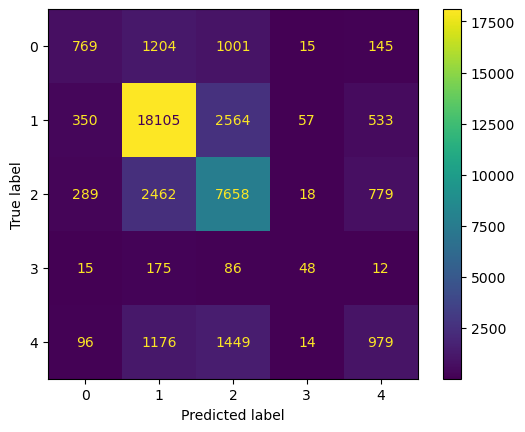

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Optionally, display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    ConfusionMatrixDisplay
)
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np

# Assuming you already have X, y, label_dict, and num_classes
# label_dict maps labels to class names
num_classes = len(label_dict)


# Accuracy
test_acc = knn.score(X_test, y_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
report = classification_report(y_test, y_pred, target_names=list(label_dict.values()))
print("Classification Report:")
print(report)

# AUC scores
y_test_cat = to_categorical(y_test, num_classes=num_classes)
auc_scores = []
for i in range(num_classes):
    try:
        auc = roc_auc_score(y_test_cat[:, i], y_pred_probs[:, i])
    except:
        auc = None
    auc_scores.append(auc)
    class_name = list(label_dict.keys())[i]
    print(f"Class {class_name} AUC: {auc:.3f}" if auc is not None else f"Class {class_name} AUC: N/A")

# Store results
method = 'KNN'
results = {}
report_dicts = {}

results[method] = {
    'accuracy': test_acc,
    'auc': auc_scores,
    'confusion_matrix': cm
}

report_dicts[method] = classification_report(
    y_test, y_pred, target_names=list(label_dict.keys()), output_dict=True
)


Confusion Matrix:
[[  769  1204  1001    15   145]
 [  350 18105  2564    57   533]
 [  289  2462  7658    18   779]
 [   15   175    86    48    12]
 [   96  1176  1449    14   979]]
Classification Report:
              precision    recall  f1-score   support

       drink       0.51      0.25      0.33      3134
        food       0.78      0.84      0.81     21609
      inside       0.60      0.68      0.64     11206
        menu       0.32      0.14      0.20       336
     outside       0.40      0.26      0.32      3714

    accuracy                           0.69     39999
   macro avg       0.52      0.43      0.46     39999
weighted avg       0.67      0.69      0.67     39999

Class 0 AUC: 0.671
Class 1 AUC: 0.863
Class 2 AUC: 0.827
Class 3 AUC: 0.707
Class 4 AUC: 0.728
